In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import random
%matplotlib inline
print "Done"

Done


In [2]:
pickle_file = 'dataset.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (90000, 32, 32, 1), (90000,))
('Validation set', (10000, 32, 32, 1), (10000,))
('Test set', (26032, 32, 32, 1), (26032,))


Display some of the images just to make sure everything is fine

In [3]:
IMAGE_SIZE=32
N_CHANNELS=1
NUM_LABELS=10
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.
BATCH_SIZE=64

In [4]:
def display_images_at_random(dataset, labels):
    # random.seed(1)
    
    f, axarr = plt.subplots(3, 3, figsize=(8,8))
    
    for i in range(3):
        for j in range(3):
            img_rand_index = random.randrange(0,dataset.shape[0])
            axarr[i, j].imshow(dataset[img_rand_index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + " Index: " + str(img_rand_index))

    plt.show()

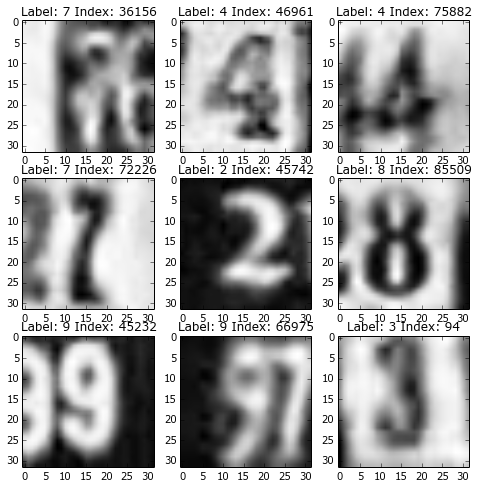

In [5]:
display_images_at_random(train_dataset, train_labels)

In [6]:
# verify if the data is well balanced across the classes
def display_data_distribution(labels):
    data_distribution = np.bincount(labels)

    index = np.arange(10)
    plt.bar(index, data_distribution)
    plt.title("Display the number of Samples per class label")
    plt.xlabel('Classes')
    plt.ylabel('Samples')

    bar_width = 0.35
    plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))

    plt.show()

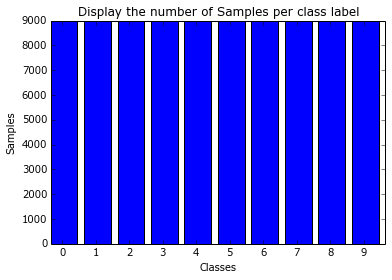

In [7]:
display_data_distribution(train_labels)

In [8]:
def reformat(dataset, labels):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Train set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Train set', (90000, 32, 32, 1), (90000, 10))
('Validation set', (10000, 32, 32, 1), (10000, 10))
('Test set', (26032, 32, 32, 1), (26032, 10))


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


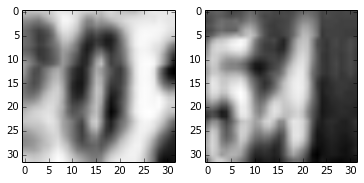

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2)

img = train_dataset[2,:,:]
ax1.imshow(img.reshape(32,32), cmap=plt.cm.Greys);
print train_labels[2]

img = train_dataset[19757,:,:]
ax2.imshow(img.reshape(32,32), cmap=plt.cm.Greys);
print train_labels[19757]

In [10]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (90000, 32, 32, 1), (90000, 10))
('Validation set', (10000, 32, 32, 1), (10000, 10))
('Test set', (26032, 32, 32, 1), (26032, 10))


In [11]:
x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="train_dataset_planceholder")

y_ = tf.placeholder(tf.float32, shape=[None, NUM_LABELS], name="train_labels_placeholder")

keep_prob = tf.placeholder(tf.float32, name="dropout")

tf_valid_dataset = tf.constant(valid_dataset, name="validation_dataset")
tf_valid_dataset = tf.cast(tf_valid_dataset, tf.float32)

tf_test_dataset = tf.constant(test_dataset, name="test_dataset")
tf_test_dataset = tf.cast(tf_test_dataset, tf.float32)

In [12]:
def weight_variable(shape, stddev=1e-1):
  initial = tf.truncated_normal(shape, stddev=stddev)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(value=0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
print "Done"

Done


In [13]:
def _variable_on_cpu(name, shape, initializer):
  """Helper to create a Variable stored on CPU memory.
  Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
  Returns:
    Variable Tensor
  """
  with tf.device('/cpu:0'):
    var = tf.get_variable(name, shape, initializer=initializer)
  return var


def _variable_with_weight_decay(name, shape, stddev, wd):
  """Helper to create an initialized Variable with weight decay.
  Note that the Variable is initialized with a truncated normal distribution.
  A weight decay is added only if one is specified.
  Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.
  Returns:
    Variable Tensor
  """
  var = _variable_on_cpu(name, shape,
                         tf.truncated_normal_initializer(stddev=stddev))
  if wd is not None:
    weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
  return var

In [141]:
CONV1_DEPTH=16
W_conv1 = weight_variable([5, 5, N_CHANNELS, CONV1_DEPTH], stddev=0.1)
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_variable([5, 5, CONV1_DEPTH, CONV2_DEPTH], stddev=0.05)
b_conv2 = bias_variable([CONV2_DEPTH])

CONV3_DEPTH=64
W_conv3 = weight_variable([5, 5, CONV2_DEPTH, CONV3_DEPTH], stddev=0.01)
b_conv3 = bias_variable([CONV3_DEPTH])

FC1_SIZE = 96
W_fc1 = weight_variable([4 * 4 * CONV3_DEPTH, FC1_SIZE], stddev=0.1)
b_fc1 = bias_variable([FC1_SIZE])

FC2_SIZE = 256
W_fc2 = weight_variable([FC1_SIZE, FC2_SIZE], stddev=0.08)
b_fc2 = bias_variable([FC2_SIZE])

FC3_SIZE = 256
W_fc3 = weight_variable([FC2_SIZE, FC3_SIZE], stddev=0.08)
b_fc3 = bias_variable([FC3_SIZE])

read_output_layer = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias = bias_variable([NUM_LABELS])

In [142]:
def model(x_image):   
    # conv1
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
    # pool1
    h_pool1 = max_pool_2x2(h_conv1)

    # norm1
    norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')
    
    # conv2
    h_conv2 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
    
    # norm2
    norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
    # pool2
    h_pool2 = max_pool_2x2(norm2)
    
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    
    # norm3
    norm3 = tf.nn.lrn(h_pool3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')    

    shape = norm3.get_shape().as_list()  
    h_pool3_flat = tf.reshape(norm3, [-1, shape[1] * shape[2] * shape[3]])
    
    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    #h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    # Second fully connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    #h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)
    
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)

    return tf.matmul(h_fc3, read_output_layer) + read_output_bias

In [143]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f367d778c50>> ignored


In [144]:
logits = model(x)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) + 
                tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(b_fc3))

# Add the regularization term to the loss.
loss += 4e-4 * regularizers

# Add a scalar summary for the snapshot loss.
loss_summary = tf.scalar_summary("loss summary", loss)

# Create a variable to track the global step.
global_step = tf.Variable(0, name='global_step', trainable=False)
DECAY_RATE = 0.94   # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.01       # Initial learning rate.
learning_rate = tf.train.exponential_decay(INITIAL_LEARNING_RATE, 
                                           global_step * BATCH_SIZE,
                                           int(train_labels.shape[0] / 4), 
                                           DECAY_RATE, 
                                           staircase=True)

learning_rate_summary = tf.scalar_summary("learning rate summary", learning_rate)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

momentum = 0.9
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum').minimize(loss, global_step=global_step)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_summary([learning_rate_summary])
train_writer = tf.train.SummaryWriter('./summary/train',
                                      s.graph)

valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

print "Done"

Done


In [145]:
# Initialize all the variables we defined above.
init= tf.initialize_all_variables()
s.run(init)

In [146]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [152]:
total_steps = int(train_labels.shape[0] / BATCH_SIZE)

for step in xrange(total_steps):
  offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
  batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
  batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
  
  feed_dict = {x : batch_data, y_ : batch_labels, keep_prob : 0.5}
  
  # Run the graph and fetch some of the nodes.
  _, l, predictions, lr, gl = s.run([optimizer, loss, train_prediction, 
                                     learning_rate, global_step], 
                                     feed_dict=feed_dict)

  if step % 10 == 0:
    summary = s.run(merged)
    
  if step % 100 == 0:
    acc = accuracy(predictions, batch_labels)
    print('Minibatch loss at step %d: %f\tLearning rate:%f' % (gl, l, lr))
    print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    print('Validation accuracy: %.1f%%' % accuracy(
           valid_prediction.eval({keep_prob : 1.0}), valid_labels))
    print ('Traning data amount used so far: %d : %d' % (offset, (offset + BATCH_SIZE)))
    print "=================================================="
print "Done training"

Minibatch loss at step 7031: 0.291557	Learning rate:0.003086
Minibatch accuracy: 96.9%
Validation accuracy: 92.2%
Traning data amount used so far: 0 : 64
Minibatch loss at step 7131: 0.295726	Learning rate:0.002901
Minibatch accuracy: 95.3%
Validation accuracy: 92.2%
Traning data amount used so far: 6400 : 6464
Minibatch loss at step 7231: 0.365155	Learning rate:0.002901
Minibatch accuracy: 96.9%
Validation accuracy: 91.7%
Traning data amount used so far: 12800 : 12864
Minibatch loss at step 7331: 0.279628	Learning rate:0.002901
Minibatch accuracy: 96.9%
Validation accuracy: 92.3%
Traning data amount used so far: 19200 : 19264
Minibatch loss at step 7431: 0.438400	Learning rate:0.002727
Minibatch accuracy: 93.8%
Validation accuracy: 92.2%
Traning data amount used so far: 25600 : 25664
Minibatch loss at step 7531: 0.272054	Learning rate:0.002727
Minibatch accuracy: 96.9%
Validation accuracy: 92.2%
Traning data amount used so far: 32000 : 32064
Minibatch loss at step 7631: 0.315550	Learn

In [123]:
def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([10, 10], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [124]:
test_error, confusions = error_rate(test_prediction.eval({keep_prob : 1.0}), test_labels)
print 'Test error: %.1f%%' % test_error

Test error: 9.3%


Done


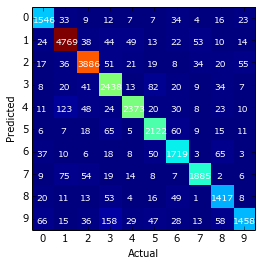

In [125]:
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
  for j, count in enumerate(cas):
    if count > 0:
      xoff = .07 * len(str(count))
      plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
print 'Done'